**Aplicação de técnicas de classificação de texto na arquitetura de Chatbots hierárquicos**

**Mestrado Profissional em Computação Aplicada - PPCA - Universidade de Brasília**

**Disciplina**: Mineração de Dados

**Orientador**: Prof. Dr. Marcelo Ladeira <mladeira@unb.br>

**Alunos**: 
 - José Ronaldo Agra De Souza Filho <jose.agra@aluno.unb.br>
 - Bruno Gomes Resende <bruno.resende@aluno.unb.br>
 - Célio Castro Wermelinger <celio.wermelinger@aluno.unb.br> 

**Palavras-Chave:**

Chatbot; Text Classification; Machine Learning; Text Mining; NLP;

In [1]:
# Install packages
# Note: use Python 3.8 env
#!pip install --pre pycaret

In [2]:
# Import packages
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from pycaret.classification import *
import pandas as pd

# download das stopwords para o idioma português
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ronal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Montagem do dataset
df_covid = pd.read_csv('data/exemplos-treinamento-covid.csv', delimiter=';')
df_seloturismo = pd.read_csv('data/exemplos-treinamento-seloturismo.csv', delimiter=';')
df_tuberculose = pd.read_csv('data/exemplos-treinamento-tuberculose.csv', delimiter=';')
df_teste = pd.read_csv('data/dados-testes-experimentos.csv', delimiter=';')

df_all = pd.concat([df_covid, df_seloturismo, df_tuberculose, df_teste], axis=0)
df_all.reset_index(drop=True, inplace=True)
df_all['category'] = df_all.reset_index().category.map({'covid':0, 'seloturismo':1, 'tuberculose':2})

df_all.describe()

,category
count,1199.000000
mean,1.041701
std,0.652410
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,2.000000


In [4]:
# recupera as stopwords do idioma português
stop_words = stopwords.words('portuguese')

# vetorização das palavras
tv = TfidfVectorizer(lowercase=True, stop_words=stop_words, strip_accents='unicode', token_pattern="[A-Za-z]+")

tf_idf_dados = tv.fit_transform(df_all['input'])

# vetorização para o dataframe referente à categoria COVID
df_dados_vetorizados = pd.DataFrame(tf_idf_dados.toarray(), columns=tv.get_feature_names())
df_dados_vetorizados['target_cat'] = df_all.reset_index().category

dados_treino_validacao = df_dados_vetorizados.sample(frac=0.8, random_state=786).reset_index(drop=True)
dados_teste = df_dados_vetorizados.drop(dados_treino_validacao.index).reset_index(drop=True)

print('Data for Modeling: ' + str(dados_treino_validacao.shape))
print('Unseen Data For Predictions: ' + str(dados_teste.shape))

dados_treino_validacao

Data for Modeling: (959, 1497)
Unseen Data For Predictions: (240, 1497)


,abdomen,abracar,abrace,abraco,acessibilidade,acesso,acho,acionar,acometer,acometidos,acompanhados,acompanhamento,acontece,acontecera,acordo,acougue,acrescido,acrescimo,acrescimos,adequada,aderi,aderir,aderiram,aderiu,adesao,adesoes,adianta,adiantou,adicionais,adicional,adocao,adoecem,adoecimento,adota,adotadas,adotado,adotando,adotar,adotaram,adotarem,adotou,adultos,adverso,aerossois,aferir,afeta,afetadas,afetar,afetem,africa,agencia,agir,aglomeracoes,agora,agressiva,agressivas,agua,ainda,ajuda,ajudara,albergaria,albergues,alcool,alem,alguem,algum,alguma,alimentar,alimentos,alojam,alojar,ambientais,ambiental,ambiente,ambientes,animais,ano,anos,antes,anticorpo,antiga,antigo,anvisa,aparece,apareceu,aparelho,apenas,aperto,apesar,aplicabilidade,aplicadas,aplicam,aplicando,aplicaveis,apoio,apontem,apos,apresenta,apresente,aprovacao,aprovadas,aprovado,aproximadamente,aptos,ar,arca,area,areas,arma,artesanato,ase,assim,assintomatico,associou,astrazeneca,asua,ate,atencao,atende,atender,atendimento,atestado,atinge,atitude,ativa,ativacao,ativado,ativara,atividade,atividades,ativo,atracoes,atrativos,atraves,atua,atualizacao,atualizacoes,atualizado,atualizar,atualizarei,atuando,auditorias,aumenta,aumentam,aumentar,aumentarao,aumento,auto,autorizacao,aval,avalia,avaliacao,avaliada,bacilo,bacilos,baciloscopia,bacteria,bacteriana,bacterias,bacteriologico,baixa,baixar,bancos,banheiro,bares,base,bcg,bebedouro,beber,bebida,bebidas,beijo,beijos,bem,beneficios,bexiga,biosseguranca,boas,boca,br,brasil,brasileiro,bubcar,buscar,busco,butantan,cabelo,cada,cadastrado,cadastrados,cadastramento,cadastrar,cadastro,cadastrotur,cadastrur,cadastur,cadtrur,cadtur,calendario,calmette,caminhada,cancelar,capacidade,capacitados,carne,carro,cartao,casa,caseiro,caso,casos,catarro,causa,causada,causam,causando,cd,cedula,central,cerca,cerebral,cerebro,certeza,certificacao,cgu,chama,chance,chegar,cheio,cheiro,china,chineses,cidadao,circulacao,circulando,circular,clientes,clinico,clique,cliquei,cobertura,cobrada,cobrado,cobrar,cobrir,code,coemcou,coisa,coisas,colaboradores,...,sair,sairam,saiu,sanguinea,sanitaria,sanitarias,sanitario,sao,sarar,sars,saude,seca,secrecoes,sedex,segmento,segue,segui,seguido,seguindo,seguintes,seguir,segunda,segura,seguranca,seguras,seguro,seguros,sei,seis,sel,selecionei,selo,selos,semanas,sempre,sendo,sensibilidade,sensivel,sentido,sentindo,sentir,sentira,sentirao,sequenciamento,sera,serao,serve,servico,servicos,setor,setores,setorias,severa,sido,significa,sim,similares,sinalizacao,sinalizacoes,sinovac,sintam,sintoma,sintomas,sistema,sistematizadas,site,situacao,so,sobre,sobrevive,sociais,sofrerao,sol,solar,solicitacao,solicitar,status,subdividido,submetidos,sucesso,sugestiva,sujos,sul,superficies,supermercado,surgir,surjam,sus,suspeitos,suspendi,suspensa,suspensao,suspensas,sustentabilidade,sustentam,tabaco,tabela,talheres,tambem,tanto,tapete,taxa,taxas,tb,tbsnc,tecido,tecidos,tecnico,tempo,tendencia,ter,tera,terao,terbeculose,teste,testes,tiberculose,tipo,tipos,tira,tirar,toalha,tocando,tocar,toda,todas,todo,todos,tomado,tomar,tomei,torax,tornar,tornara,tosse,tossir,trabalho,tradicional,transmissao,transmissivel,transmite,transmitida,transmitido,transmitidos,transmitir,transportadoras,transporte,transversais,trara,trasmitida,tratamento,tratar,traves,traz,treinamento,tres,trm,troca,tuberculose,tuberculosis,tuberculoso,tudo,turismo,turista,turistas,turistica,turisticas,turistico,turisticos,tussa,uber,umida,unhas,uniao,unico,unidade,unido,urinaria,urinario,usa,usada,usar,uso,usuario,usuarios,usufluir,utensilhos,utilizacao,utilizados,utilizando,utilizar,vacina,vacinacao,vacinada,vacinadas,vacinado,vacinal,vacinar,vacinas,vai,validacao,validade,validados,valor,valorizacao,vantagem,vantagens,vantajoso,vao,variacao,variante,variantes,varias,varios,varrer,vc,veiculos,veio,vejo,vem,vendi,ver,verduras,verificar,verificara,verifico,via,viagem,viajar,vias,vida,vigilancia,vindo,vir,virilha,virus,visita,visitar,visivel,vistoria,vistoriar,vistorias,vi

In [5]:
# Setup
# Iniciando os recursos da biblioteca, passando como alvo a coluna 'class' do dataset
setup = setup(data=dados_treino_validacao, target='target_cat', session_id=20221,
              train_size = 0.7, test_data=dados_teste, fold=10, silent=True, fix_imbalance=True)

,Description,Value
0,session_id,20221
1,Target,target_cat
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(959, 1497)"
5,Missing Values,False
6,Numeric Features,754
7,Categorical Features,742
8,Ordinal Features,False
9,High Cardinality Features,False


In [16]:
metricas = get_metrics()
metricas

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x0000016E7C1218B0>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<function roc_auc_score at 0x0000016E7C1175E0>,"make_scorer(roc_auc_score, needs_proba=True, e...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, average=macro)",pred,{'average': 'macro'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x0000016E7C121...,make_scorer(cohen_kappa_score),pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x0000016E7C121...,make_scorer(matthews_corrcoef),pred,{},True,True,False


In [6]:
# Gerando modelos com diferentes abordagens e escolhendo o melhor por cross-validation
modelos = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9687,0.9969,0.9603,0.9702,0.9687,0.9463,0.9471,0.3070
rf,Random Forest Classifier,0.9656,0.9961,0.9534,0.9674,0.9653,0.9405,0.9417,0.2420
lr,Logistic Regression,0.9646,0.9982,0.9572,0.9684,0.9651,0.9398,0.9411,1.0380
ridge,Ridge Classifier,0.9572,0.0000,0.9606,0.9615,0.9581,0.9281,0.9296,0.1330
xgboost,Extreme Gradient Boosting,0.9468,0.9917,0.9251,0.9489,0.9462,0.9073,0.9092,3.5600
dt,Decision Tree Classifier,0.9447,0.9767,0.9296,0.9482,0.9446,0.9049,0.9071,0.1100
catboost,CatBoost Classifier,0.9447,0.9952,0.9138,0.9480,0.9434,0.9027,0.9062,11.6270
gbc,Gradient Boosting Classifier,0.9427,0.9935,0.9097,0.9463,0.9411,0.8987,0.9027,1.4180
lightgbm,Light Gradient Boosting Machine,0.9249,0.9811,0.8973,0.9282,0.9243,0.8691,0.8718,0.1570
ada,Ada Boost Classifier,0.9218,0.9779,0.9075,0.9440,0.9227,0.8721,0.8833,0.2540


In [7]:
# Imprimindo melhor modelo
print(modelos)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=20221, verbose=0,
                     warm_start=False)


In [8]:
# Matriz de confusão TF-IDF
modelo = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9688,0.9988,0.9612,0.9698,0.9691,0.9465,0.9467
1,0.9792,0.9981,0.9764,0.9792,0.9792,0.9641,0.9641
2,0.9479,0.9981,0.9582,0.9530,0.9491,0.9120,0.9136
3,0.9792,0.9994,0.9680,0.9799,0.9791,0.9641,0.9647
4,0.9167,0.9887,0.8832,0.9209,0.9163,0.8557,0.8579
5,0.9896,0.9995,0.9855,0.9901,0.9896,0.9823,0.9824
6,0.9688,0.9920,0.9474,0.9704,0.9678,0.9457,0.9475
7,0.9896,0.9997,0.9855,0.9901,0.9896,0.9823,0.9824
8,0.9688,0.9986,0.9732,0.9691,0.9687,0.9471,0.9473


In [9]:
# realiza o ensemble dos modelos e seleciona o melhor
melhor_modelo_bagging = ensemble_model(modelo, choose_better=True, return_train_score=True)

In [10]:
# Imprimindo melhor modelo
print(melhor_modelo_bagging)

BaggingClassifier(base_estimator=ExtraTreesClassifier(bootstrap=False,
                                                      ccp_alpha=0.0,
                                                      class_weight=None,
                                                      criterion='gini',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      max_samples=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                              

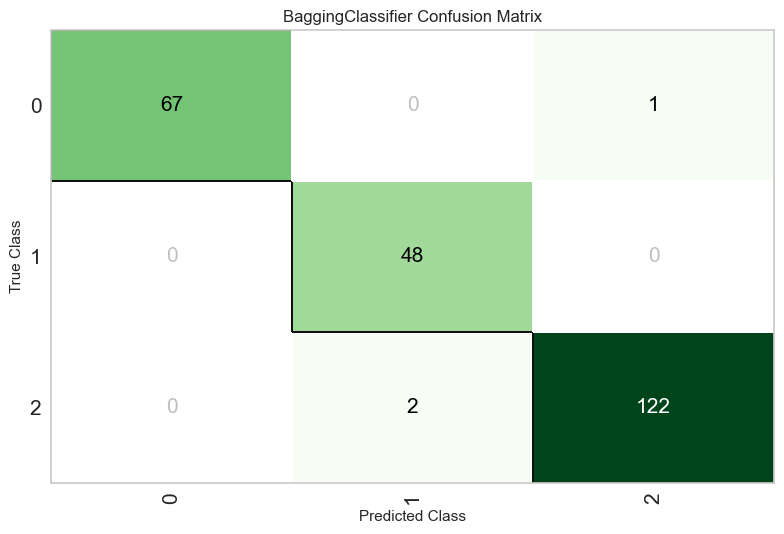

In [11]:
plot_model(melhor_modelo_bagging, plot = 'confusion_matrix')

## Predição

In [12]:
# Realizando predição com dateset de validação
predict_model(modelo)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9917,0.9997,0.9924,0.9918,0.9917,0.9864,0.9864


,abdomen,acessibilidade,acesso,acho,acometidos,acompanhamento,acontece,aderir,aderiram,aderiu,...,vantajoso_0.8132408261299133,varias_0.0,verificara_0.43883538246154785,vindo_0.0,vistorias_0.7109053134918213,vivem_0.5207983255386353,vulneravel_0.0,target_cat,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2,2,1.00
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2,2,1.00
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2,2,1.00
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2,2,1.00
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2,2,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,1.00
236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,1.00
237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.60
238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,1.00


In [13]:
modelo_final = finalize_model(melhor_modelo_bagging)
predicoes = predict_model(modelo_final)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9875,0.9995,0.9897,0.9878,0.9875,0.9797,0.9797


In [14]:
predicoes.head(200)


,abdomen,acessibilidade,acesso,acho,acometidos,acompanhamento,acontece,aderir,aderiram,aderiu,...,vantajoso_0.8132408261299133,varias_0.0,verificara_0.43883538246154785,vindo_0.0,vistorias_0.7109053134918213,vivem_0.5207983255386353,vulneravel_0.0,target_cat,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2,2,0.9960
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2,2,0.9944
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2,2,1.0000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2,2,1.0000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2,2,0.9660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.9941
196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.9254
197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.8068
198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.9480


In [15]:
save_model(modelo_final,'models/20220914-modelo-final-multiclasses-tdidf-et')


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='target_cat', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_...
                                                                        min_impurity_split=None,
                                                                        min_samples_leaf=1,
                                                                        min_samples_s